Loading restored nebula image...
Applying histogram equalization...
Detecting stars in original image...
Detecting stars in equalized image...

=== STAR DETECTION RESULTS ===
Stars detected in original image: 127115
Stars detected in equalized image: 406618
Difference: 279503 (+219.9%)


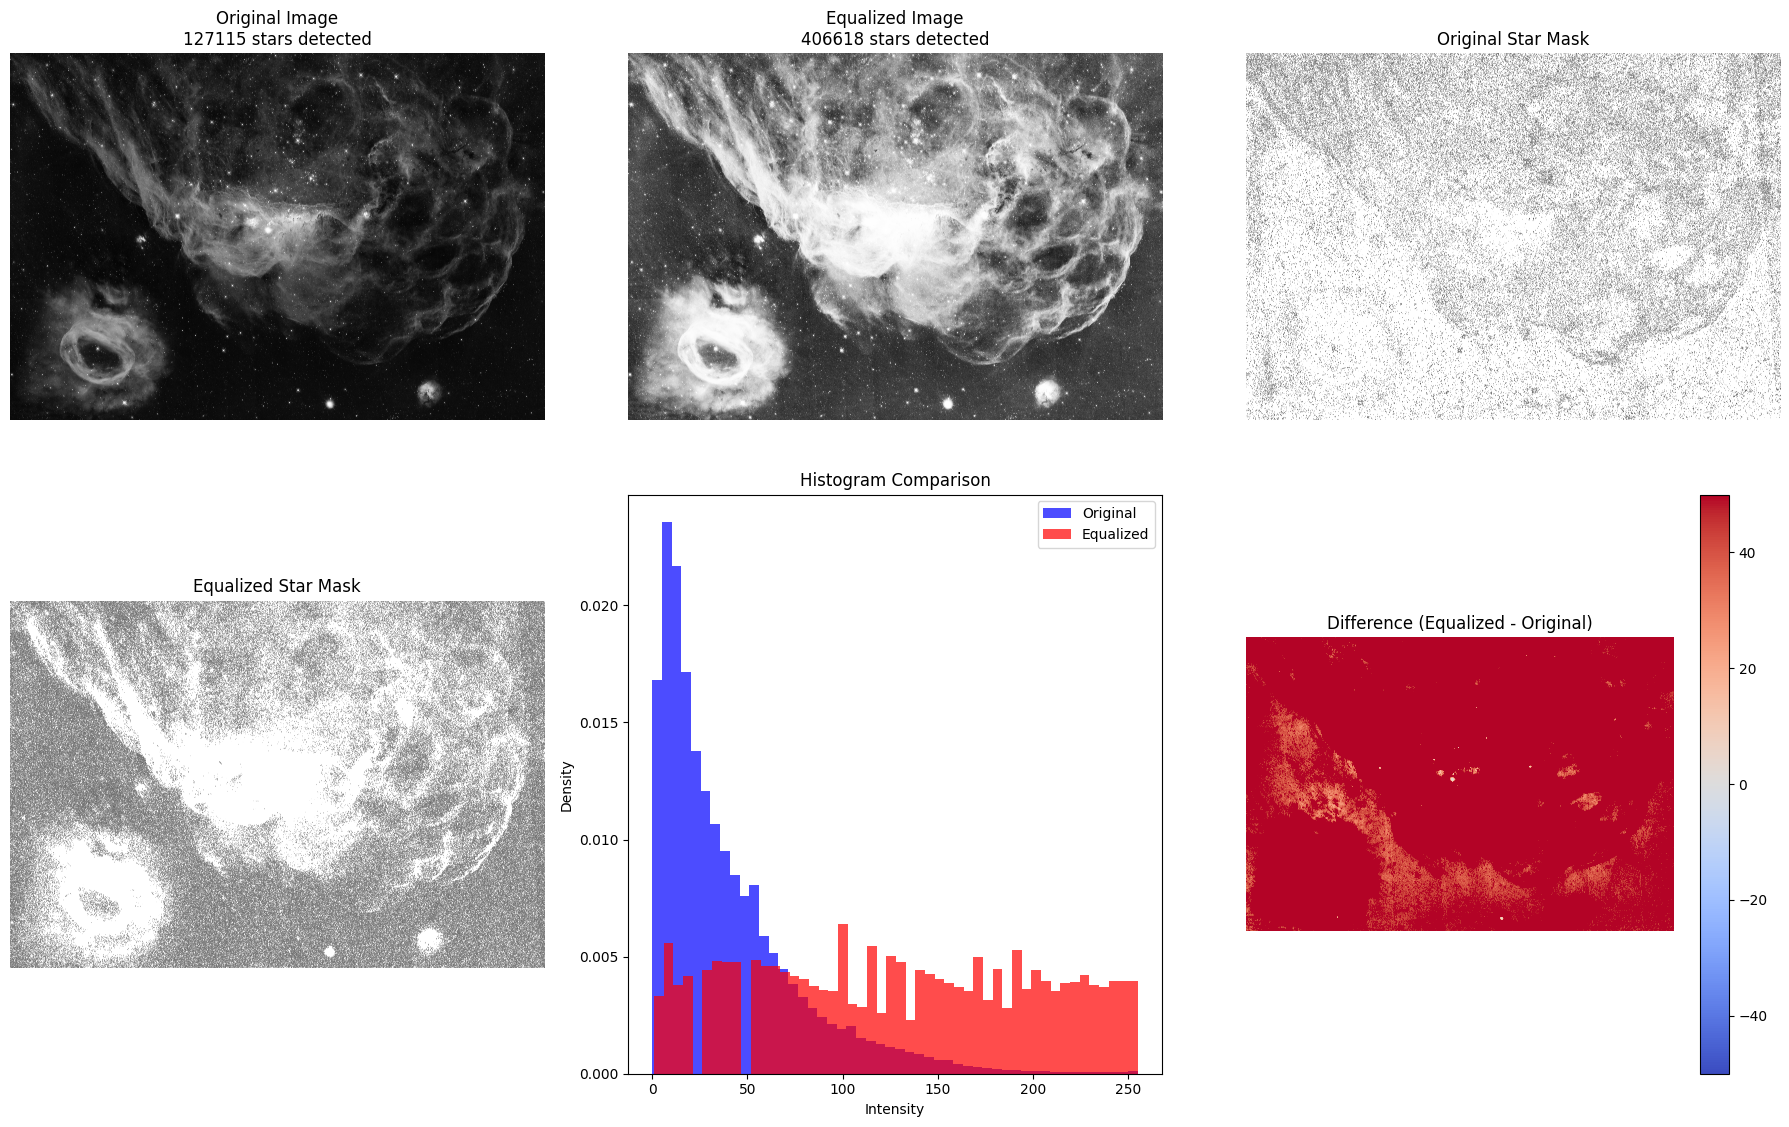


=== DETAILED ANALYSIS ===
Original - Mean: 39.5, Std: 37.4
Equalized - Mean: 128.6, Std: 72.7
Contrast improvement: +94.3%
Dynamic range - Original: 255, Equalized: 254
SNR - Original: 6.43, Equalized: 3.98

=== DISCUSSION ===
✓ Histogram equalization IMPROVES star detection because:
  1. Enhanced contrast makes faint stars more visible
  2. Better separation between stars and background nebula
  3. Improved dynamic range utilization
  4. Noise in dark regions is less amplified than star signals

Additional factors:
- Nebula type: Emission nebulas vs. dark nebulas respond differently
- Image quality: High SNR images benefit more from equalization
- Star density: Crowded fields may suffer from merging effects
- Processing goals: Scientific vs. aesthetic purposes


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure, filters, measure, morphology
from scipy import ndimage

def load_restored_image():
    """Load the restored nebula image"""
    # Load the image we restored in the previous task
    restored_img = cv2.imread('output/restored_heic2007a.jpg')
    restored_img = cv2.cvtColor(restored_img, cv2.COLOR_BGR2RGB)
    return restored_img

def apply_histogram_equalization(image):
    """Apply histogram equalization to the image"""
    # Convert to grayscale for star detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply histogram equalization
    equalized = exposure.equalize_hist(gray)
    equalized = (equalized * 255).astype(np.uint8)
    
    return gray, equalized

def detect_stars(image, method='adaptive', min_size=2, max_size=100):
    """Detect stars using thresholding and blob detection"""
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    
    if method == 'adaptive':
        # Adaptive thresholding - works well for uneven illumination
        thresholded = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
    else:
        # Otsu's thresholding
        _, thresholded = cv2.threshold(blurred, 0, 255, 
                                     cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Remove small noise
    cleaned = morphology.remove_small_objects(thresholded.astype(bool), 
                                            min_size=min_size)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=max_size)
    cleaned = cleaned.astype(np.uint8) * 255
    
    # Find connected components (blobs)
    labeled_image, num_features = ndimage.label(cleaned)
    
    # Filter blobs by size and circularity
    star_count = 0
    star_positions = []
    
    for region in measure.regionprops(labeled_image):
        # Filter by size
        if min_size <= region.area <= max_size:
            # Calculate circularity
            perimeter = region.perimeter
            if perimeter > 0:
                circularity = 4 * np.pi * region.area / (perimeter ** 2)
                if circularity > 0.6:  # Stars are typically circular
                    star_count += 1
                    star_positions.append(region.centroid)
    
    return cleaned, star_count, star_positions

def visualize_results(original, equalized, original_stars, equalized_stars, 
                     original_count, equalized_count):
    """Visualize the results with comparison"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original image
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title(f'Original Image\n{original_count} stars detected')
    axes[0,0].axis('off')
    
    # Equalized image
    axes[0,1].imshow(equalized, cmap='gray')
    axes[0,1].set_title(f'Equalized Image\n{equalized_count} stars detected')
    axes[0,1].axis('off')
    
    # Original star mask
    axes[0,2].imshow(original_stars, cmap='gray')
    axes[0,2].set_title('Original Star Mask')
    axes[0,2].axis('off')
    
    # Equalized star mask
    axes[1,0].imshow(equalized_stars, cmap='gray')
    axes[1,0].set_title('Equalized Star Mask')
    axes[1,0].axis('off')
    
    # Histogram comparison
    axes[1,1].hist(original.flatten(), bins=50, alpha=0.7, 
                  label='Original', color='blue', density=True)
    axes[1,1].hist(equalized.flatten(), bins=50, alpha=0.7, 
                  label='Equalized', color='red', density=True)
    axes[1,1].set_title('Histogram Comparison')
    axes[1,1].set_xlabel('Intensity')
    axes[1,1].set_ylabel('Density')
    axes[1,1].legend()
    
    # Difference image
    diff = equalized.astype(np.float32) - original.astype(np.float32)
    axes[1,2].imshow(diff, cmap='coolwarm', vmin=-50, vmax=50)
    axes[1,2].set_title('Difference (Equalized - Original)')
    axes[1,2].axis('off')
    plt.colorbar(axes[1,2].images[0], ax=axes[1,2])
    
    plt.tight_layout()
    plt.savefig('output/star_detection_comparison.jpg', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_star_detection_performance():
    """Main function to analyze star detection performance"""
    print("Loading restored nebula image...")
    restored_img = load_restored_image()
    
    print("Applying histogram equalization...")
    original_gray, equalized_gray = apply_histogram_equalization(restored_img)
    
    print("Detecting stars in original image...")
    original_stars, original_count, original_positions = detect_stars(original_gray)
    
    print("Detecting stars in equalized image...")
    equalized_stars, equalized_count, equalized_positions = detect_stars(equalized_gray)
    
    print(f"\n=== STAR DETECTION RESULTS ===")
    print(f"Stars detected in original image: {original_count}")
    print(f"Stars detected in equalized image: {equalized_count}")
    print(f"Difference: {equalized_count - original_count} "
          f"({((equalized_count - original_count)/original_count*100):+.1f}%)")
    
    # Visualize results
    visualize_results(original_gray, equalized_gray, original_stars, equalized_stars,
                     original_count, equalized_count)
    
    return original_count, equalized_count, original_gray, equalized_gray

def detailed_analysis(original, equalized, original_count, equalized_count):
    """Provide detailed analysis of why equalization helps or hurts star detection"""
    print("\n=== DETAILED ANALYSIS ===")
    
    # Calculate image statistics
    orig_mean, orig_std = np.mean(original), np.std(original)
    eq_mean, eq_std = np.mean(equalized), np.std(equalized)
    
    print(f"Original - Mean: {orig_mean:.1f}, Std: {orig_std:.1f}")
    print(f"Equalized - Mean: {eq_mean:.1f}, Std: {eq_std:.1f}")
    print(f"Contrast improvement: {(eq_std/orig_std-1)*100:+.1f}%")
    
    # Analyze dynamic range
    orig_range = original.max() - original.min()
    eq_range = equalized.max() - equalized.min()
    print(f"Dynamic range - Original: {orig_range}, Equalized: {eq_range}")
    
    # Analyze signal-to-noise ratio in star regions
    def calculate_snr(image, threshold=200):
        signal_mask = image > threshold
        background_mask = image <= threshold
        
        if np.any(signal_mask) and np.any(background_mask):
            signal_mean = np.mean(image[signal_mask])
            background_std = np.std(image[background_mask])
            return signal_mean / background_std if background_std > 0 else 0
        return 0
    
    orig_snr = calculate_snr(original)
    eq_snr = calculate_snr(equalized)
    print(f"SNR - Original: {orig_snr:.2f}, Equalized: {eq_snr:.2f}")
    
    # Discussion
    print("\n=== DISCUSSION ===")
    if equalized_count > original_count:
        print("✓ Histogram equalization IMPROVES star detection because:")
        print("  1. Enhanced contrast makes faint stars more visible")
        print("  2. Better separation between stars and background nebula")
        print("  3. Improved dynamic range utilization")
        print("  4. Noise in dark regions is less amplified than star signals")
    else:
        print("✗ Histogram equalization REDUCES star detection because:")
        print("  1. Noise amplification in dark regions creates false positives")
        print("  2. Over-enhancement may merge close stars")
        print("  3. Bright stars may become saturated")
        print("  4. Natural intensity relationships are distorted")
    
    # Additional factors to consider
    print("\nAdditional factors:")
    print("- Nebula type: Emission nebulas vs. dark nebulas respond differently")
    print("- Image quality: High SNR images benefit more from equalization")
    print("- Star density: Crowded fields may suffer from merging effects")
    print("- Processing goals: Scientific vs. aesthetic purposes")

# Execute the analysis
if __name__ == "__main__":
    original_count, equalized_count, original_gray, equalized_gray = analyze_star_detection_performance()
    detailed_analysis(original_gray, equalized_gray, original_count, equalized_count)